В нашем распоряжении данные о пользователях одного развлекательного приложения, привлечённых с 1 мая по 27 октября 2019 года.   
**Ситуация**: несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.
   
Три датасета:   
* файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта;
* файл `orders_info_short.csv` — информацию о заказах;
* файл `costs_info_short.csv` — информацию о расходах на рекламу.
   
Нам предстоит изучить:
* откуда приходят пользователи и какими устройствами они пользуются,
* сколько стоит привлечение пользователей из различных рекламных каналов;
* сколько денег приносит каждый клиент,
* когда расходы на привлечение клиента окупаются,
* какие факторы мешают привлечению клиентов.

Структура `visits_info_short.csv`:
* `User Id` — уникальный идентификатор пользователя,
* `Region` — страна пользователя,
* `Device` — тип устройства пользователя,
* `Channel` — идентификатор источника перехода,
* `Session Start` — дата и время начала сессии,
* `Session End` — дата и время окончания сессии.   
   
Структура `orders_info_short.csv`:
* `User Id` — уникальный идентификатор пользователя,
* `Event Dt` — дата и время покупки,
* `Revenue` — сумма заказа.
   
Структура `costs_info_short.csv`:
* `dt` — дата проведения рекламной кампании,
* `Channel` — идентификатор рекламного источника,
* `costs` — расходы на эту кампанию.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

### Загрузка данных и подготовка к анализу

In [2]:
visits = pd.read_csv('visits_info_short.csv')
orders = pd.read_csv('orders_info_short.csv')
ad_costs = pd.read_csv('costs_info_short.csv')

display(visits.head(5))
display(orders.head(5))
display(ad_costs.head(5))

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_st', 'session_end']

In [5]:
visits['session_st'] = pd.to_datetime(visits['session_st'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [6]:
for name in visits.columns[1:4] :
    print(visits[name].unique())

['United States' 'UK' 'France' 'Germany']
['iPhone' 'Mac' 'Android' 'PC']
['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [8]:
orders.columns = ['user_id', 'event_dt', 'revenue']

In [9]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [10]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [11]:
ad_costs.columns = ad_costs.columns.str.lower()

In [12]:
ad_costs['dt'] = pd.to_datetime(ad_costs['dt']).dt.date

In [13]:
# убедимся в отсутствии дубликатов в каждой таблице
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(ad_costs.duplicated().sum())

0
0
0


Дубликатов и пропусков нет, данные приведены к нужным типам. Можно начинать исследование.

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии.   
Для проведения анализа нам понадобятся несколько функций.   
   
Функции для вычисления значений метрик:
- `get_profiles()` — для создания профилей пользователей (первый вход, источник привлечения, устройство и регион пользователя, совершил ли пользователь покупку, рекламные затраты на привлечения пользователя),
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:
- `filter_data()` — для сглаживания данных, устранения "шумов",
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [14]:
# введём функцию, которая сделает профили пользователей
def get_profiles(visits, orders, ad_costs):
        # сортируем сессии по ID пользователя и дате привлечения
        # группируем по ID и находим параметры первых посещений
    profiles = (
            visits.sort_values(by=['user_id', 'session_st'])
            .groupby('user_id')
            .agg(
                {
                    'session_st': 'first',
                    'channel': 'first',
                    'device': 'first',
                    'region': 'first',
                }
            )
            .rename(columns={'session_st': 'first_ts'})
            .reset_index()  # возвращаем user_id из индекса
        )

        # для когортного анализа определяем дату первого посещения, 
        # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

        # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
        # считаем количество уникальных пользователей
        # с одинаковыми источником и датой привлечения
    new_users = (
            profiles.groupby(['dt', 'channel'])
            .agg({'user_id': 'nunique'})
             # столбец с числом пользователей назовём unique_users
            .rename(columns={'user_id': 'unique_users'})
            .reset_index()  # возвращаем dt и channel из индексов
        )
        # объединяем траты на рекламу и число привлечённых пользователей
        # по дате и каналу привлечения

    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
        # делим рекламные расходы на число привлечённых пользователей
        # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

        # добавим стоимость привлечения в профили
    profiles = profiles.merge(
            ad_costs[['dt', 'channel', 'acquisition_cost']],
            on=['dt', 'channel'],
            how='left',
        )
        # органические пользователи не связаны с данными о рекламе,
        # поэтому в столбце acquisition_cost у них значения NaN
        # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    # возвращаем профили
    return profiles

In [15]:
# введём функцию, которая посчитает retention rate
# передадим функции профили пользователей, момент и горизонт анализа,
# признаки пользователей, по которым считаем retention rate (например, регион) и параметр для учёта/игнорирования горизонта анализа
def get_retention(profiles, visits, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions
    
    # исключаем пользователей, не «доживших» до горизонта анализа 
    # тех, которые присоединились позже, чем observation_date - horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw_ret = profiles.query('dt <= @last_suitable_acquisition_date')
    # собираем «сырые» данные для расчёта удержания
    result_raw_ret = result_raw_ret.merge(visits[['user_id', 'session_st']], on = 'user_id', how = 'left')
    result_raw_ret['lifetime'] = (result_raw_ret['session_st'] - result_raw_ret['first_ts']).dt.days
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждую «ячейку» на соответствующий размер когорты и получаем retention rate
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # исключаем все лайфтаймы, превышающие горизонт анализа
        result['cohort_size'] = cohort_sizes                                                                     # восстанавливаем размеры когорт
        return result
    
    # получаем таблицу удержания
    result_ret = group_by_dimensions(result_raw_ret, dimensions, horizon_days)
    
    # получаем таблицу динамики удержания
    result_in_time_ret = group_by_dimensions(result_raw_ret, dimensions + ['dt'], horizon_days)
    
    # возвращаем обе таблицы и сырые данные
    # сырые данные пригодятся, если нужно будет отыскать ошибку в расчётах
    return result_raw_ret, result_ret, result_in_time_ret


In [16]:
# введём функцию, которая посчитает conversion rate, передаём аналогичные параметры, как и для функции retention rate
def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw_conv = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_orders = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw_conv = result_raw_conv.merge(
        first_orders[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw_conv['lifetime'] = (
        result_raw_conv['event_dt'] - result_raw_conv['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw_conv['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result_conv = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result_conv = result_conv.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result_conv = cohort_sizes.merge(result_conv, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result_conv = result_conv.div(result_conv['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result_conv = result_conv[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result_conv['cohort_size'] = cohort_sizes
        return result_conv

    # получаем таблицу конверсии
    result_conv = group_by_dimensions(result_raw_conv, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time_conv = group_by_dimensions(
        result_raw_conv, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw_conv, result_conv, result_in_time_conv

In [17]:
# введём функцию, которая посчитает Lifetime Value, передаём аналогичные параметры
def get_ltv(profiles, orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw_ltv = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw_ltv = result_raw_ltv.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw_ltv['lifetime'] = (
        result_raw_ltv['event_dt'] - result_raw_ltv['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw_ltv['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result_ltv = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result_ltv = result_ltv.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result_ltv = cohort_sizes.merge(result_ltv, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result_ltv = result_ltv.div(result_ltv['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result_ltv = result_ltv[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result_ltv['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result_ltv.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result_ltv, roi

    # получаем таблицы LTV и ROI
    result_ltv, roi = group_by_dimensions(
        result_raw_ltv, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time_ltv, roi_in_time = group_by_dimensions(
        result_raw_ltv, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw_ltv,  # сырые данные
        result_ltv,  # таблица LTV
        result_in_time_ltv,  # таблица динамики LTV
        roi,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [18]:
# функция сглаживания данных скользящим средним
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [19]:
# строим графики для retention rate, передаём функции таблицы удержания и динамики удержания, 
                                                                            # горизонт анализа и окно для скользящего среднего
def plot_retention(retention, retention_history, horizon, window):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [20]:
# строим графики для conversion rate, передаём таблицы конверсии и динамики конверсии, 
                                                                            # горизонт анализа и окно для скользящего среднего

def plot_conversion(conversion, conversion_history, horizon, window):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [21]:
# строим графики для LTV, CAC и ROI передаём таблицы LTV и ROI, горизонт анализа и окно для скользящего среднего
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Создание профилей пользователей

In [22]:
profiles = get_profiles(visits, orders, ad_costs)

In [23]:
profiles

user_id            first_ts       channel  device         region  \
0             599326 2019-05-07 20:58:57      FaceBoom     Mac  United States   
1            4919697 2019-07-09 12:46:07      FaceBoom  iPhone  United States   
2            6085896 2019-10-01 09:58:33       organic  iPhone         France   
3           22593348 2019-08-22 21:35:48    AdNonSense      PC        Germany   
4           31989216 2019-10-02 00:07:44       YRabbit  iPhone  United States   
...              ...                 ...           ...     ...            ...   
150003  999956196527 2019-09-28 08:33:02        TipTop  iPhone  United States   
150004  999975439887 2019-10-21 00:35:17       organic      PC             UK   
150005  999976332130 2019-07-23 02:57:06        TipTop  iPhone  United States   
150006  999979924135 2019-09-28 21:28:09  MediaTornado      PC  United States   
150007  999999563947 2019-10-18 19:57:25       organic  iPhone  United States   

                dt               month  payer  acquisition_cost  
0       2019-05-07 2019-05-07 20:58:57   True          1.088172  
1       2019-07-09 2019-07-09 12:46:07  False          1.107237  
2       2019-10-01 2019-10-01 09:58:33  False          0.000000  
3       2019-08-22 2019-08-22 21:35:48  False          0.988235  
4       2019-10-02 2019-10-02 00:07:44  False          0.230769  
...            ...                 ...    ...               ...  
150003  2019-09-28 2019-09-28 08:33:02  False          3.500000  
150004  2019-10-21 2019-10-21 00:35:17  False          0.000000  
150005  2019-07-23 2019-07-23 02:57:06  False          2.600000  
150006  2019-09-28 2019-09-28 21:28:09  False          0.205714  
150007  2019-10-18 2019-10-18 19:57:25  False          0.000000  

[150008 rows x 9 columns]

В условиях задачи было указано, что данные есть о пользователях, привлечённых с 1 мая по 27 октября 2019 года. Уточним это, проверив профили пользователей.

In [24]:
# Проверим минимальную и максимальную даты привлечения пользователей
min_date = profiles["dt"].min()
max_date = profiles["dt"].max()
print(f'минимальная дата: {min_date}, максимальная дата: {max_date}')

минимальная дата: 2019-05-01, максимальная дата: 2019-10-27


Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.   
Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [25]:
profiles.groupby('region').agg({'user_id':'nunique', 'payer':'mean'}).sort_values(by='payer', ascending=False)

user_id     payer
region                          
United States   100002  0.069019
Germany          14981  0.041119
UK               17575  0.039829
France           17450  0.037994

**Вывод:** самые высокие показатели по количеству пользователей и доле платящих пользователей у США. Германия, Великобритания и Франция имеют примерно одинаковые показатели.

Сделаем аналогичные таблицы по устройствам и канналам привлечения пользователей.

In [26]:
profiles.groupby('device').agg({'user_id':'nunique', 'payer':'mean'}).sort_values(by='payer', ascending=False)

user_id     payer
device                    
Mac        30042  0.063644
iPhone     54479  0.062079
Android    35032  0.058518
PC         30455  0.050468

**Вывод:** больше всего пользователей заходят с Iphone - 54 тыс. С Android заходит 35 тыс. пользователей, а с Mac и PC по 30 тыс.   Доля платящих пользователей по всем устройствам примерно одинаковая от 5% до 6,3%.

In [27]:
profiles.groupby('channel').agg({'user_id':'nunique', 'payer':'mean'}).sort_values(by='payer', ascending=False)

user_id     payer
channel                              
FaceBoom              29144  0.122049
AdNonSense             3880  0.113402
lambdaMediaAds         2149  0.104700
TipTop                19561  0.096007
RocketSuperAds         4448  0.079137
WahooNetBanner         8553  0.052964
YRabbit                4312  0.038265
MediaTornado           4364  0.035747
LeapBob                8553  0.030633
OppleCreativeMedia     8605  0.027077
organic               56439  0.020553

**Вывод:** Больше всего у приложения "органических" пользователей. Однако в топ-5 по доле платящих пользователей входят источники: FaceBoom, AdNonSense, lambdaMediaAds, TipTopб RocketSuper, RocketSuperAds. "Органические" пользователи на последнем месте.

#### Посчитаем общую сумму расходов на маркетинг.
Нужна информация есть в изначальной столбце `cost` таблицы `ad_costs`, а также в столбце `acquisition_cost` созданной таблицы `prfiles`. Проверим, совпадают ли значения.

In [28]:
print(profiles['acquisition_cost'].sum())
print(ad_costs['costs'].sum())

105497.29999999999
105497.30000000002


Значения совпадают, на маркетинг было потрачено 105497 $.

#### Выясним, сколько денег потратили на каждый источник.

In [29]:
ad_costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)

costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22

В абсолютных лидерах по маркетинговым затратам TipTop и FaceBoom.   
На Faceboom потрачено на 22 тыс. $ меньше чем на TipTop, однако **Faceboom привлёк на 10 тыс. больше обычных пользователей в два раза больше платящих пользователей.**

#### Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.

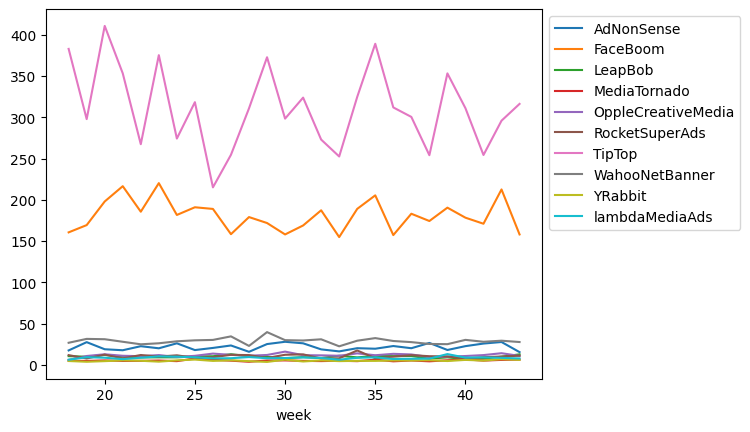

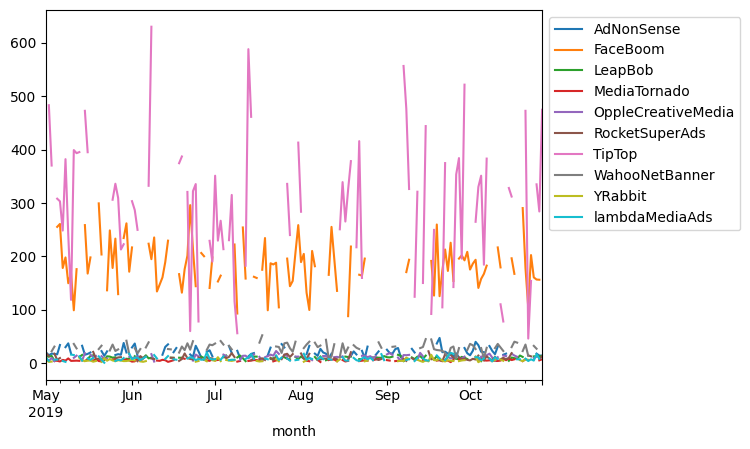

In [30]:
# добавляем недели и месяцы в таблицу расходов
ad_costs['week'] = pd.to_datetime(profiles['dt']).dt.isocalendar().week
ad_costs['month'] = pd.to_datetime(profiles['dt']).astype('datetime64[M]')

ad_costs.pivot_table(index='channel', columns='week', values='costs').T.plot()
plt.legend(bbox_to_anchor=(1,1))
ad_costs.pivot_table(index='channel', columns=['month'], values='costs').T.plot()
plt.legend(bbox_to_anchor=(1,1))
plt.show()

Исходя из графиков, основные вложения на маркетинг шли в TipTop и FaceBoom.

#### Cколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

Исключим для дальнейшего анализа "органических" пользователей для более точной оценки маркетинга. Датасет с органическими пользователями оставим в другой переменной.

In [31]:
profiles_with_org = profiles.copy()
profiles = profiles.query('channel != "organic"')

In [32]:
print(f'В среднем привлечение каждого пользователя обошлось компании в {round(profiles["acquisition_cost"].median(), 2)}$')

В среднем привлечение каждого пользователя обошлось компании в 1.08$


## Оценка окупаемости рекламы
Перейдём к ключевому этапу исследования.   
**Моментом анализа** будет 1 ноября 2019 года.   
**Горизонт анализа** - 14 дней.

In [33]:
analysis_moment = datetime(2019, 11, 1).date()
horizon_days = 14

#### Выведем графики LTV, ROI и графики динамики LTV, CAC и ROI по всем пользователям с учётом горизонта и момента анализа. 

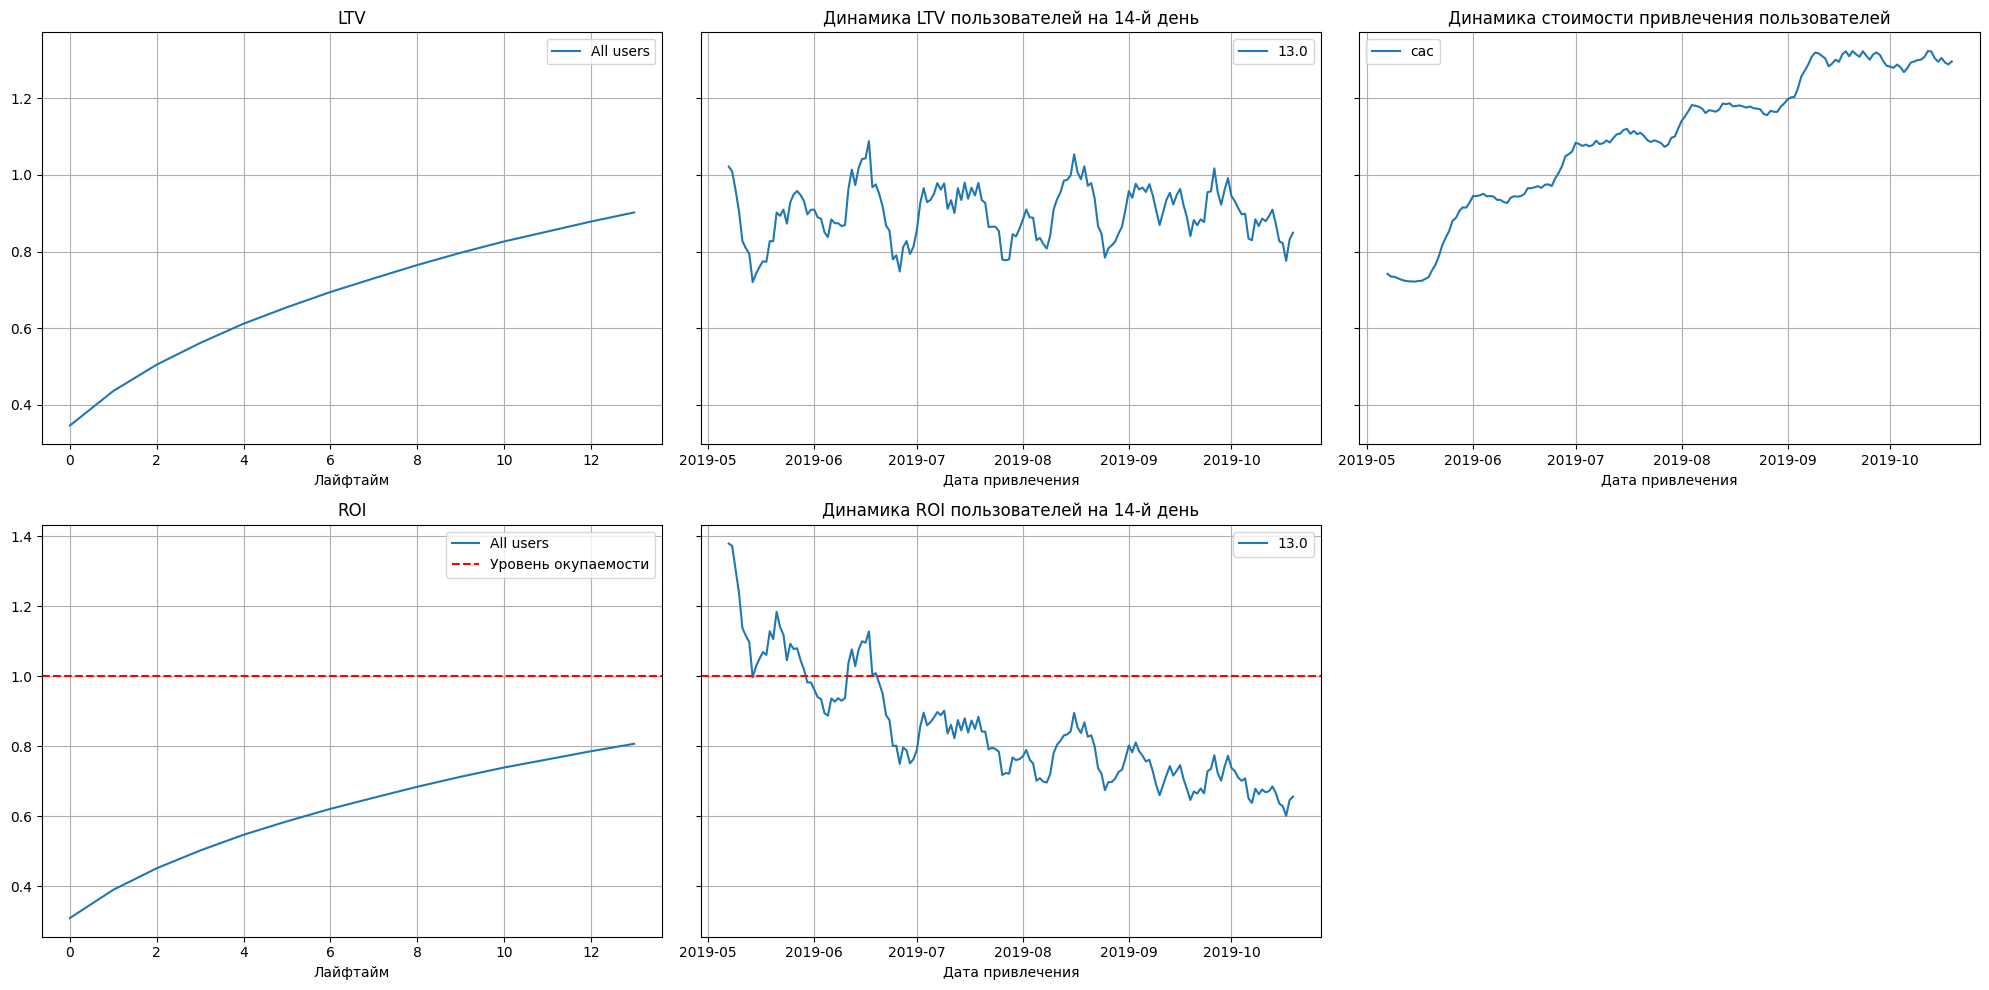

In [34]:
result_raw_ltv, result_ltv, result_in_time_ltv, roi, roi_in_time = get_ltv(
                                                                    profiles, orders, analysis_moment, horizon_days)
plot_ltv_roi(result_ltv, result_in_time_ltv, roi, roi_in_time, horizon_days)

На графиках можно отметить следующее:   
* к 14 дню «пожизненная ценность» клиента приблизилась к 0.9 доллара. В динамике значение LTV колеблется где-то между 0.8 и 1 долларом. Рекордно высокий показатель был в июне;   
* Средняя стоимость привлечения каждого клиента росла на протяжении всего периода: от 0.7 до 1.3;   
* ROI достигает лишь 80%. Следовательно, привлечение пользователя не окупается к 14 дню лайфтайма пользователя. В динамике ROI падал на протяжении всего периода. Если в мае показатель был чуть меньше 140%, то под конец снизился до 60%.    
   
**Вывод: привлечение новых пользователей стало убыточным с июля.**


#### Проверим удержание и конверсию пользователей и динамику изменений показателей. При оценки удержания пользователей разделим их на платящих и неплатящих.

В данном пункте не будем исключать органических пользователей.

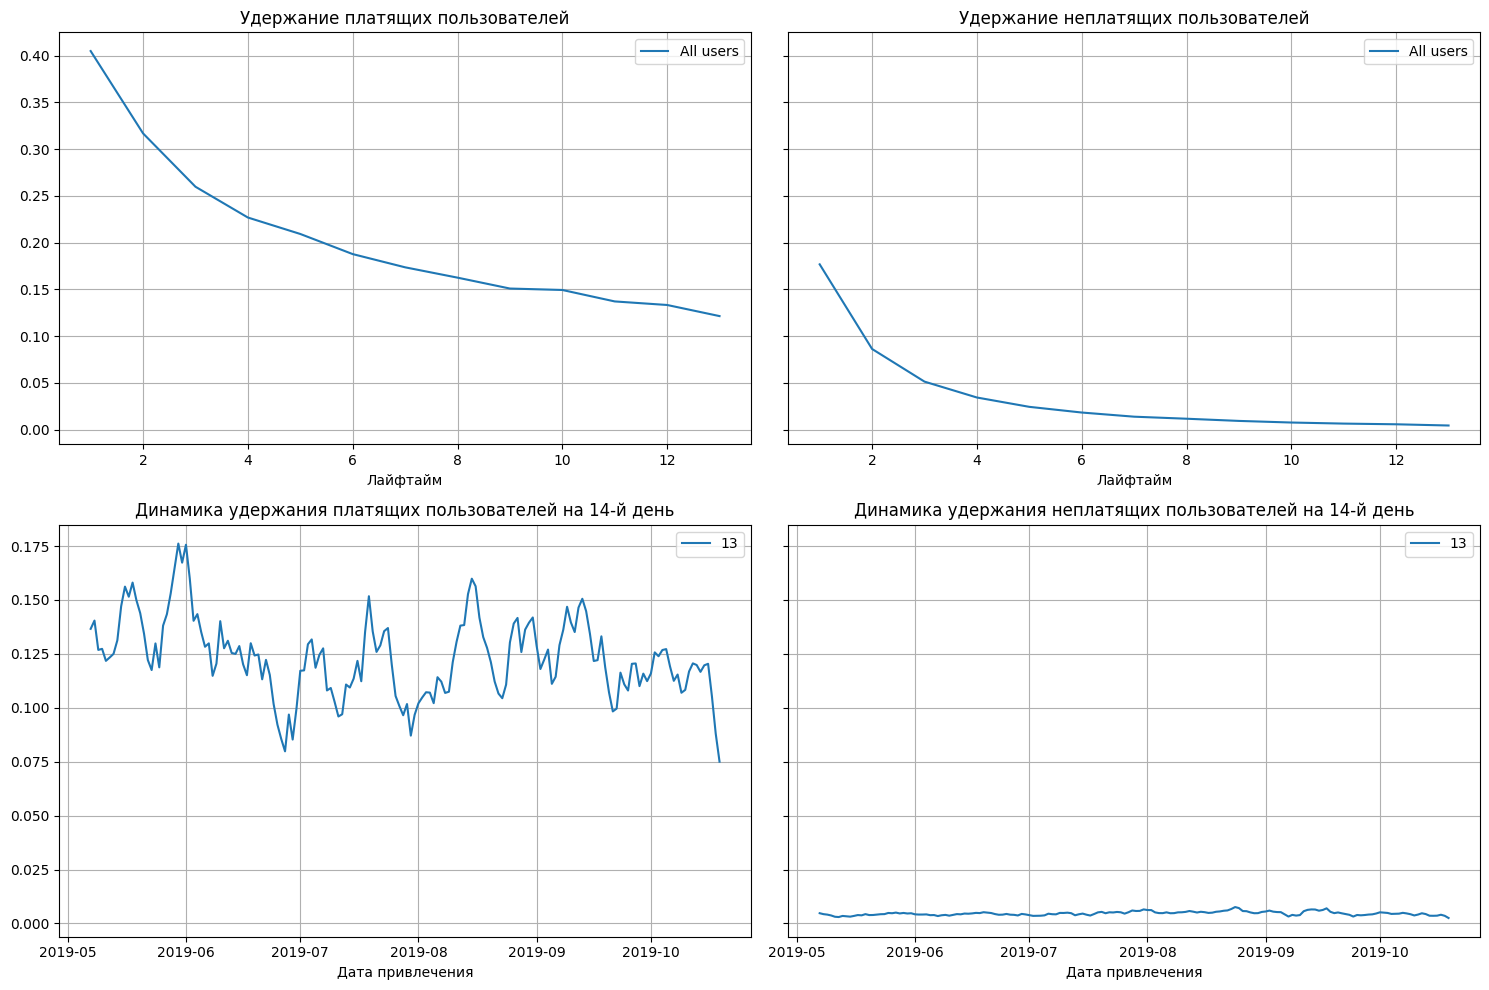

In [35]:
result_raw_ret, result_ret, result_in_time_ret= get_retention(profiles_with_org, visits, analysis_moment, horizon_days)
plot_retention(result_ret, result_in_time_ret, horizon_days, 7)

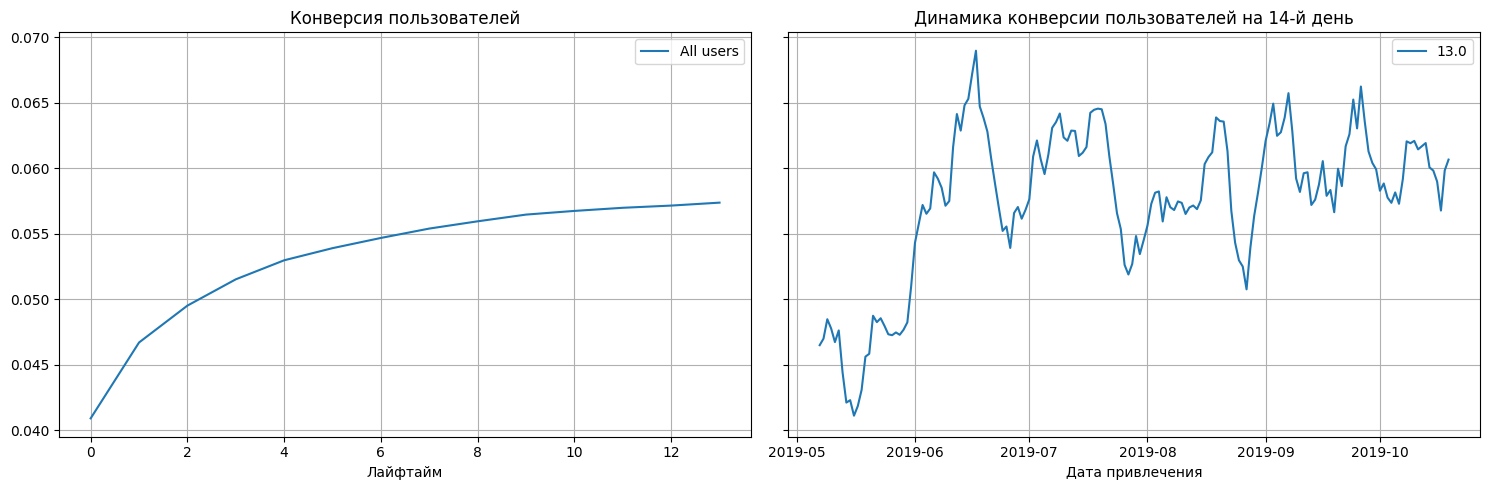

In [36]:
result_raw_conv, result_grouped_conv, result_in_time_conv = get_conversion(profiles_with_org,\
                                                                           orders, analysis_moment, horizon_days)
plot_conversion(result_grouped_conv, result_in_time_conv, horizon_days, 7)

**Вывод:** неплатящие пользователи практически не возвращаются в приложение. На протяжении всего периода Retention Rate для неплатящих пользователей был очень близок к нулю. Из платящих пользователей к 14 дню "жизни" оставалось меньше 15%.   
График конверсии показывает, что к 14 дню "жизни" 5,5% пользователей становятся платящими. В динамике конверсия выросла с мая 2019 года по ноябрь 2019 года с 4,5% до 6%.

#### Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.   

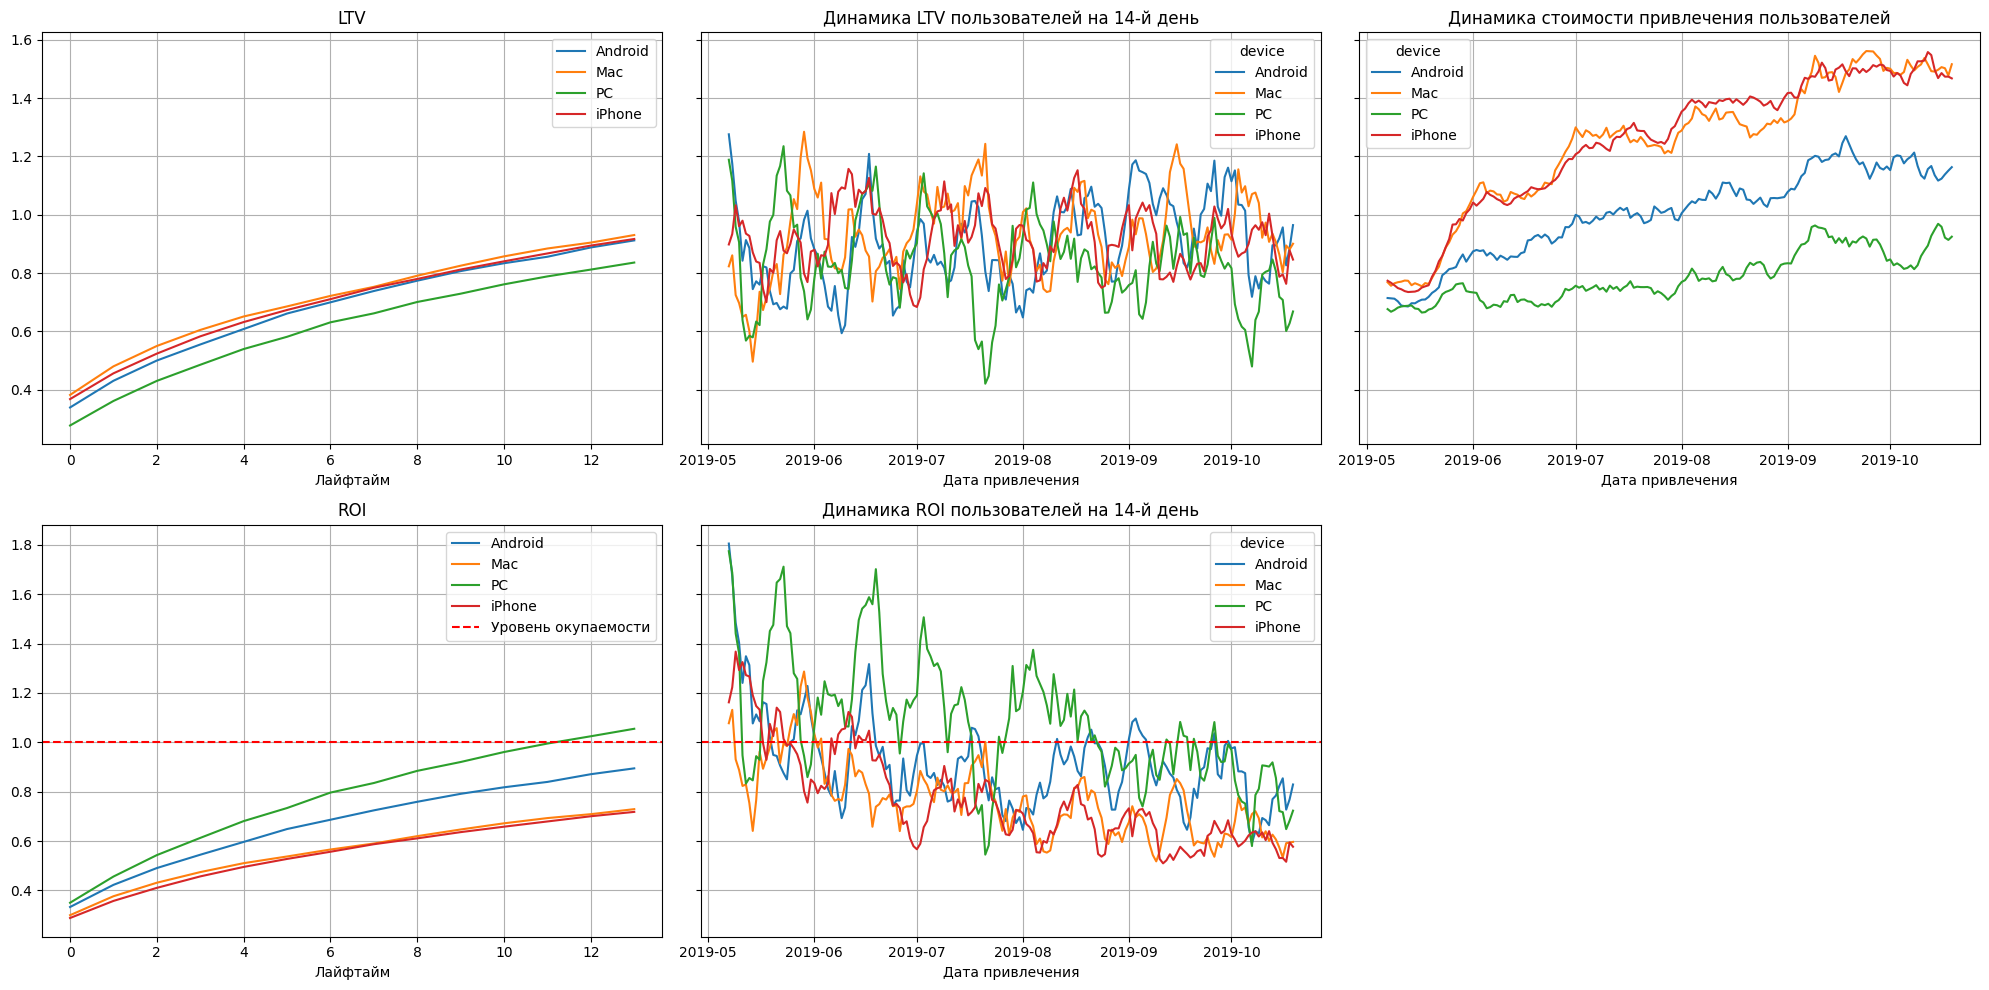

In [37]:
result_raw_ltv, result_ltv, result_in_time_ltv, roi, roi_in_time = get_ltv(
                                                                    profiles, orders, analysis_moment, horizon_days,
                                                                                            dimensions=['device'])
plot_ltv_roi(result_ltv, result_in_time_ltv, roi, roi_in_time, horizon_days)

**Вывод:** только пользователи PC окупаются. Привлечение пользователей PC и Android обходится компании дешевле, чем привлечение пользователей iPhone и Mac.  
Стоит отметить, что в динамике привлечение пользователей со всех устройств окупалось в начале мая. **К концу периода ROI по всем устройствам упал**. Скорее всего, проблема не в устройствах пользователей. 

#### Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.   

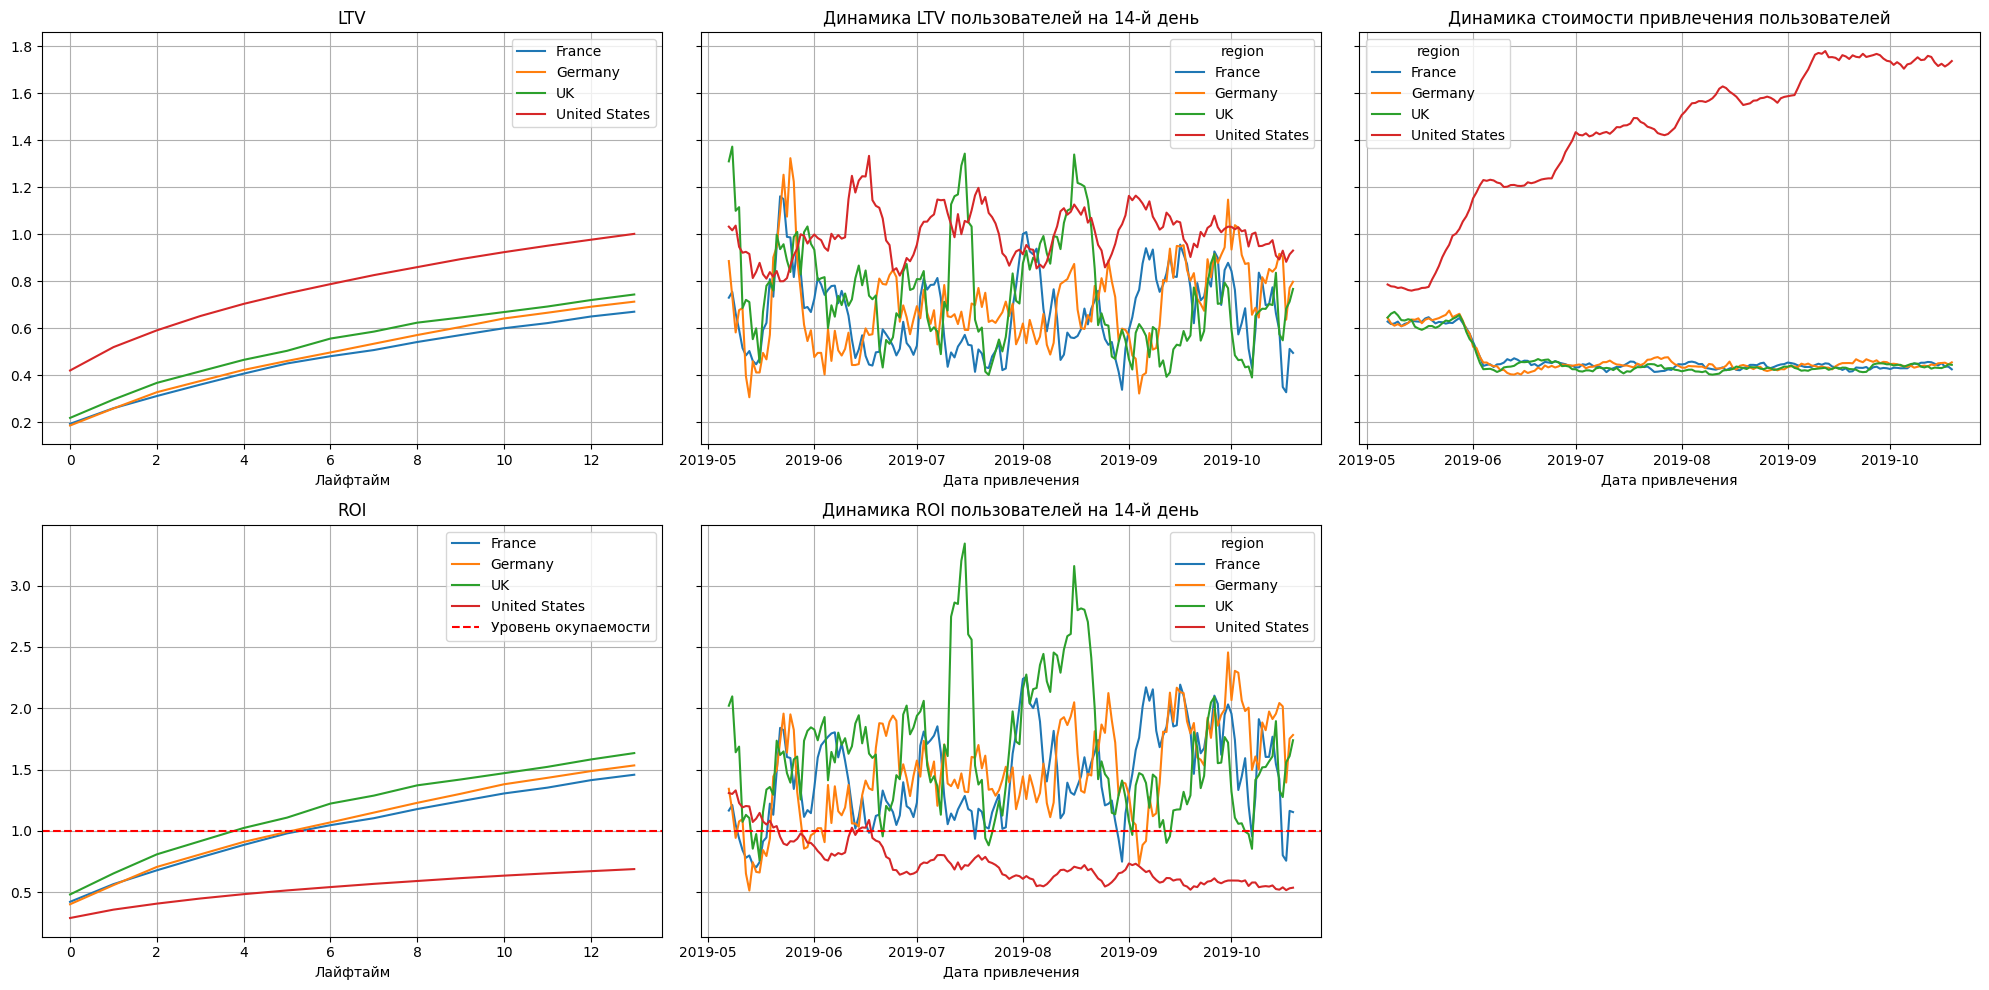

In [38]:
result_raw_ltv, result_ltv, result_in_time_ltv, roi, roi_in_time = get_ltv(
                                                                    profiles, orders, analysis_moment, horizon_days,
                                                                                            dimensions=['region'])
plot_ltv_roi(result_ltv, result_in_time_ltv, roi, roi_in_time, horizon_days)

**Вывод:** Только пользователи из США не окупаются. LTV для США чуть выше чем для остальных стран, однако **стоимость привлечения к октябрю стала в 2 раза больше**. График динамик ROI показывает, что так было не всегда. Проблемы с окупаемостью пользователей из США начались с июня. ROI по другим странам не отличается стабильностью, однако выше уровня окупаемости.

#### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.   

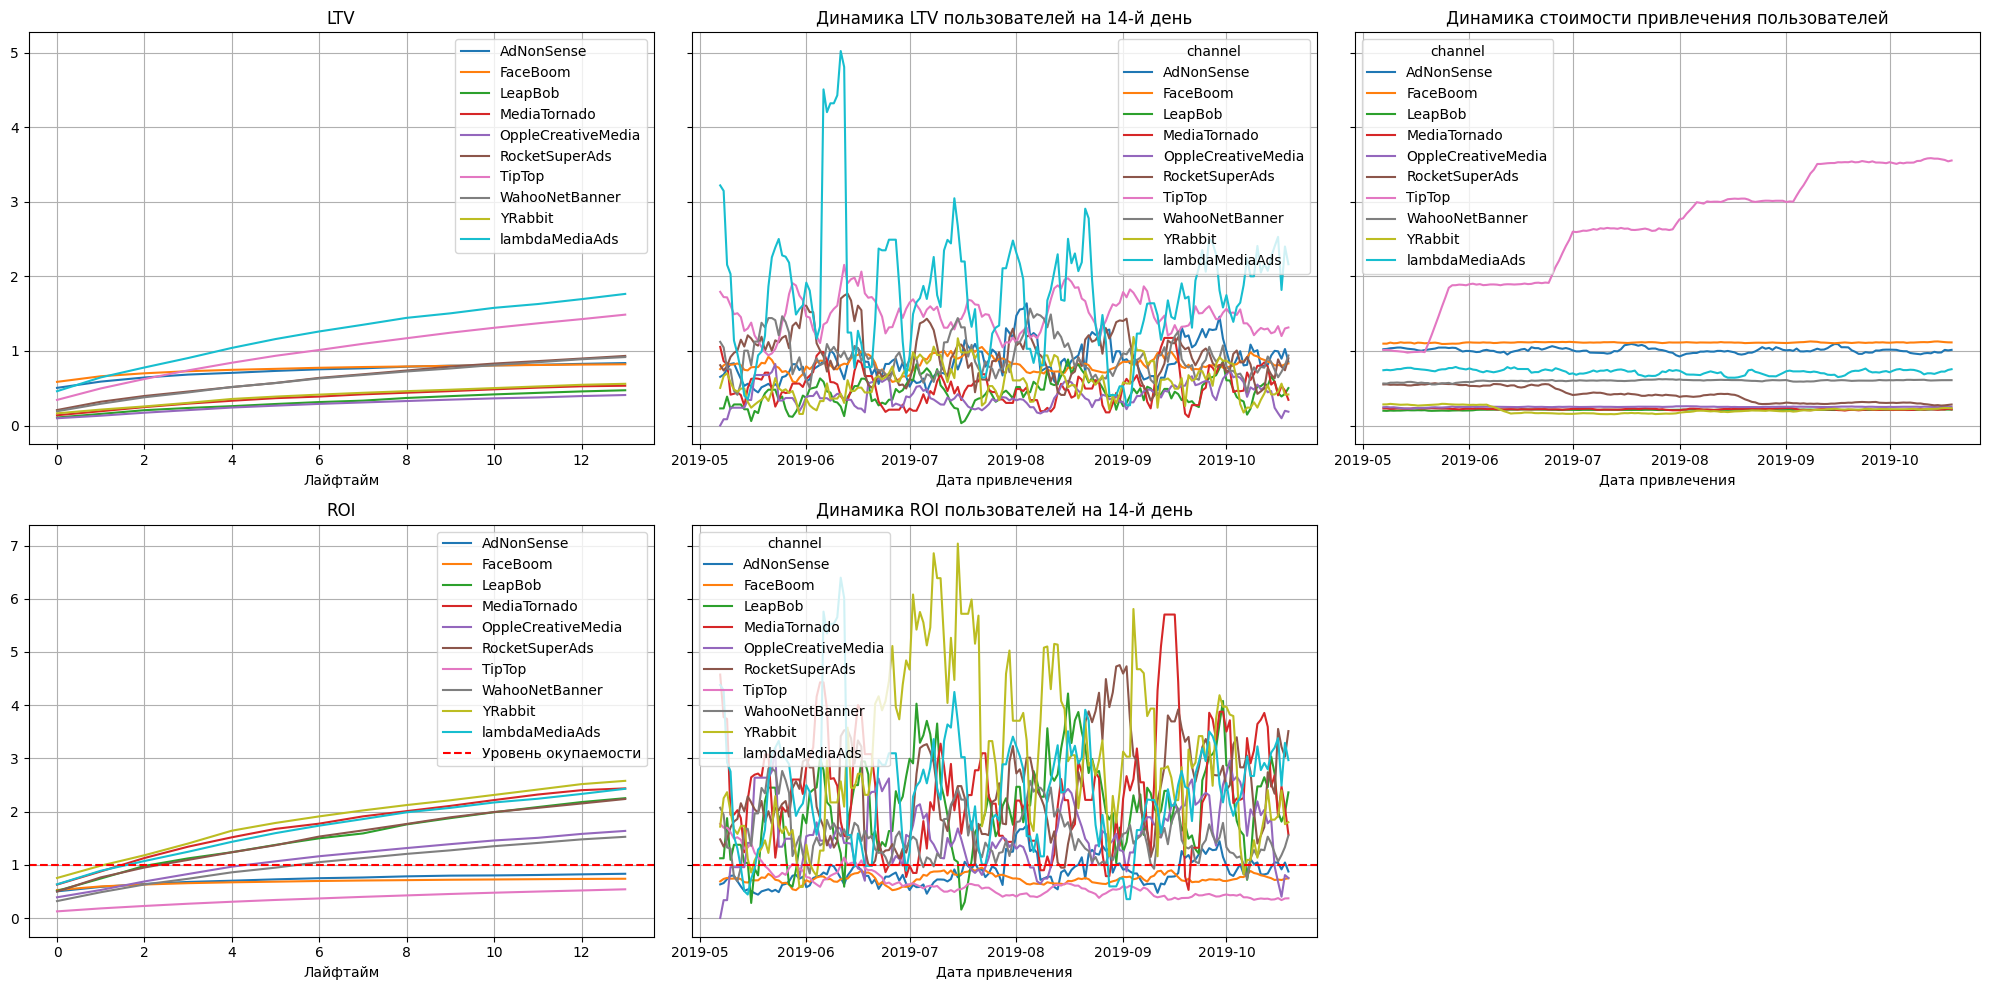

In [39]:
result_raw_ltv, result_ltv, result_in_time_ltv, roi, roi_in_time = get_ltv(
                                                                    profiles, orders, analysis_moment, horizon_days,
                                                                                            dimensions=['channel'])
plot_ltv_roi(result_ltv, result_in_time_ltv, roi, roi_in_time, horizon_days)

**Вывод:** 
не окупаются пользователи из источников AdNonSense, FaceBoom, TipTop, а самый высокий ROI у источника YRabbit.   
Отметим, что стоимость привлечения одного пользователя росла для канала TipTop. Для другиз каналов она оставалась на одном уровне.   
На графике динамики ROI к концу периода самый лучший показатель у RocketSuperAds и lambdaMediaAds.

### Отобразим ещё несколько графиков для окончательных выводов.

#### Ещё раз посмотрим графики удержания и конверсии пользователей только в разрезе по каналам, источникам и странам.

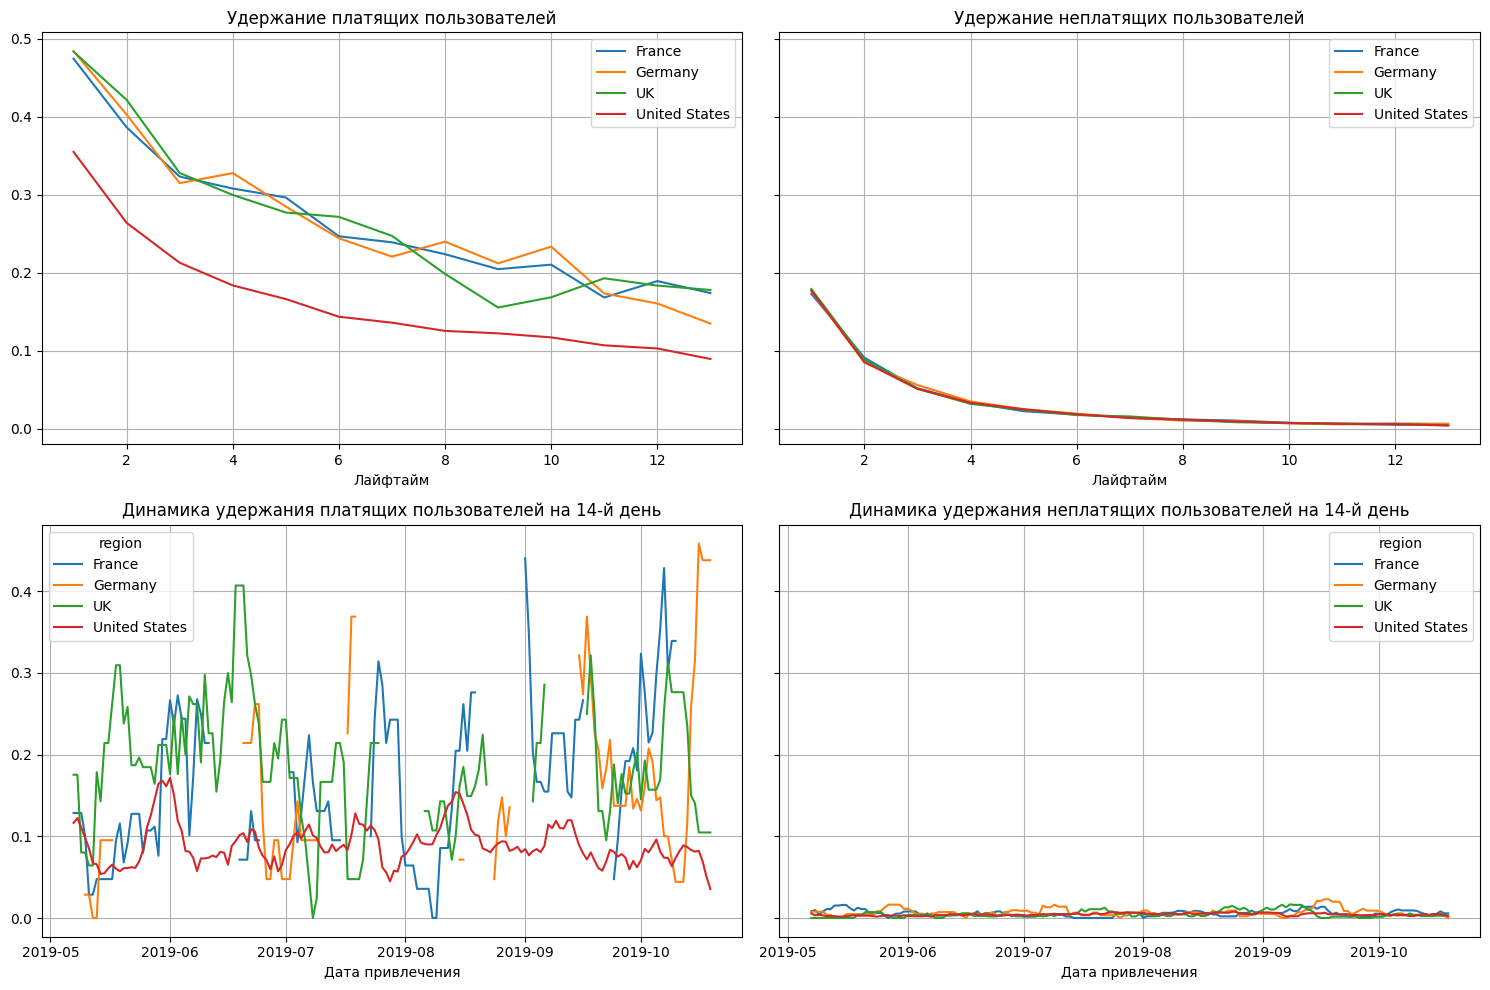

In [40]:
result_raw_ret, result_ret, result_in_time_ret= get_retention(profiles, visits, analysis_moment, horizon_days,
                                                                dimensions=['region'])
plot_retention(result_ret, result_in_time_ret, horizon_days, 7)

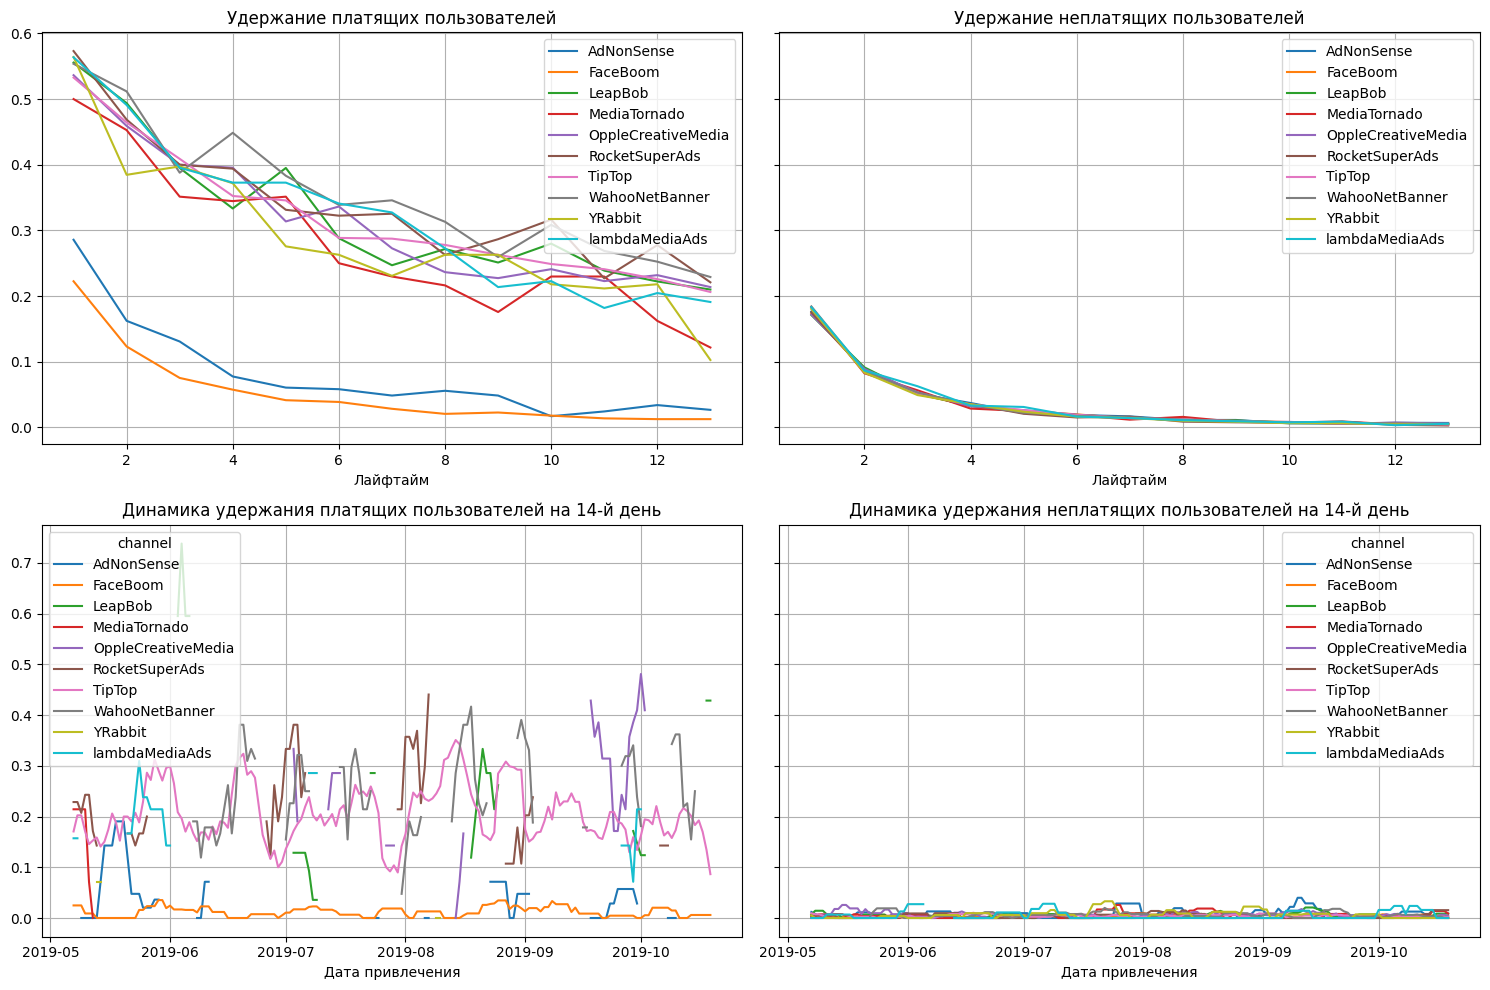

In [41]:
result_raw_ret, result_ret, result_in_time_ret= get_retention(profiles, visits, analysis_moment, horizon_days,
                                                                dimensions=['channel'])
plot_retention(result_ret, result_in_time_ret, horizon_days, 7)

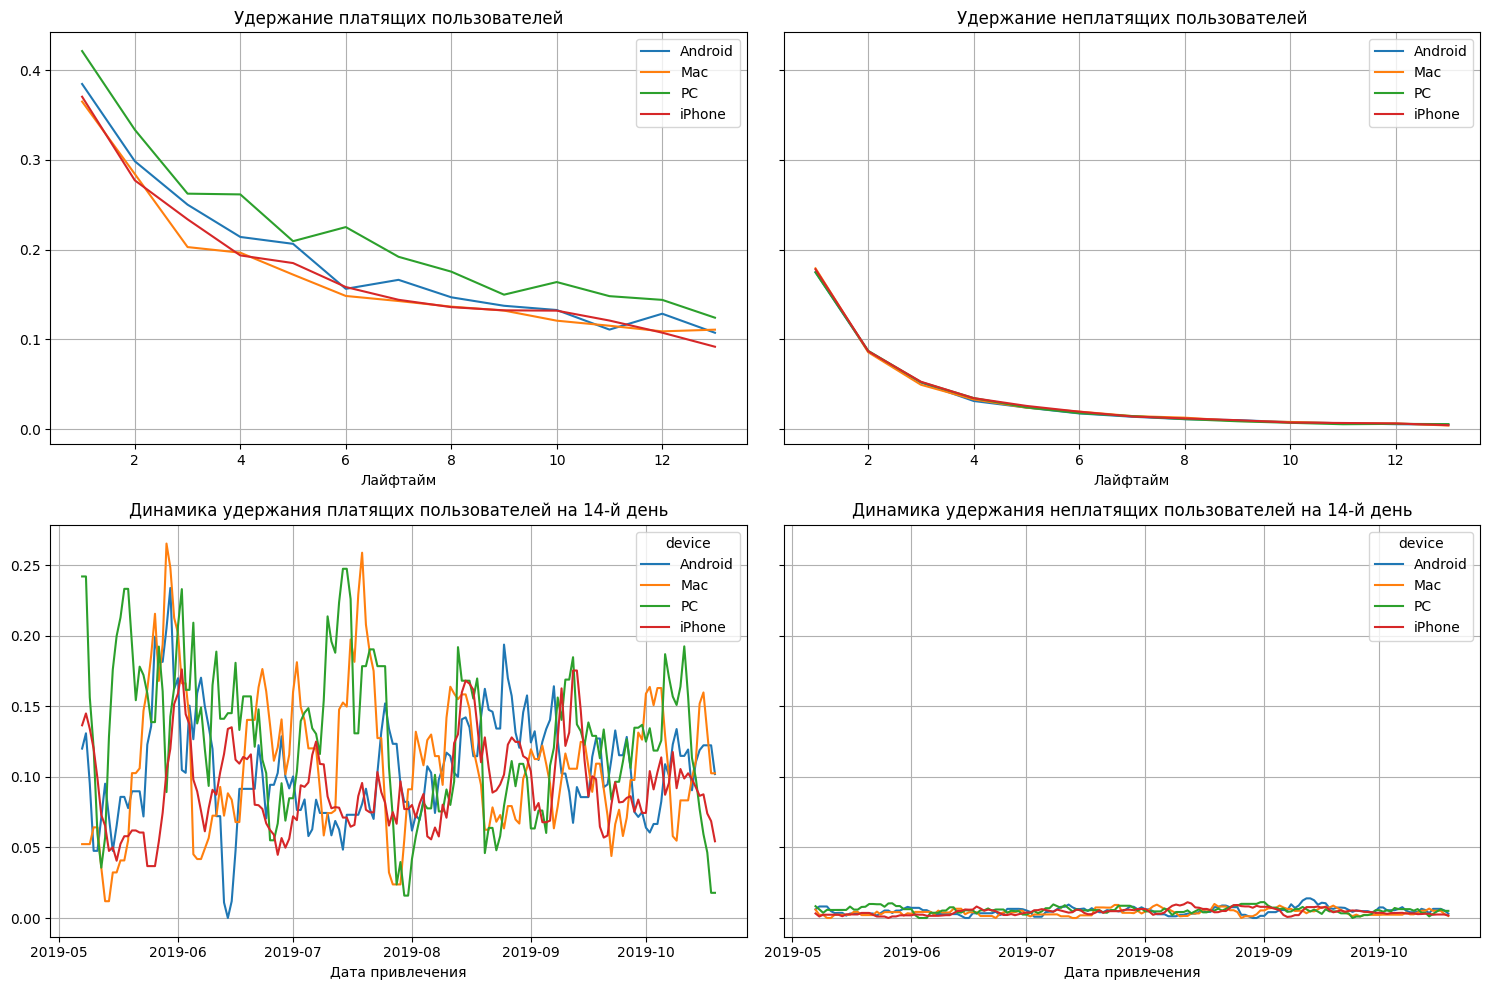

In [42]:
result_raw_ret, result_ret, result_in_time_ret= get_retention(profiles, visits, analysis_moment, horizon_days,
                                                                dimensions=['device'])
plot_retention(result_ret, result_in_time_ret, horizon_days, 7)

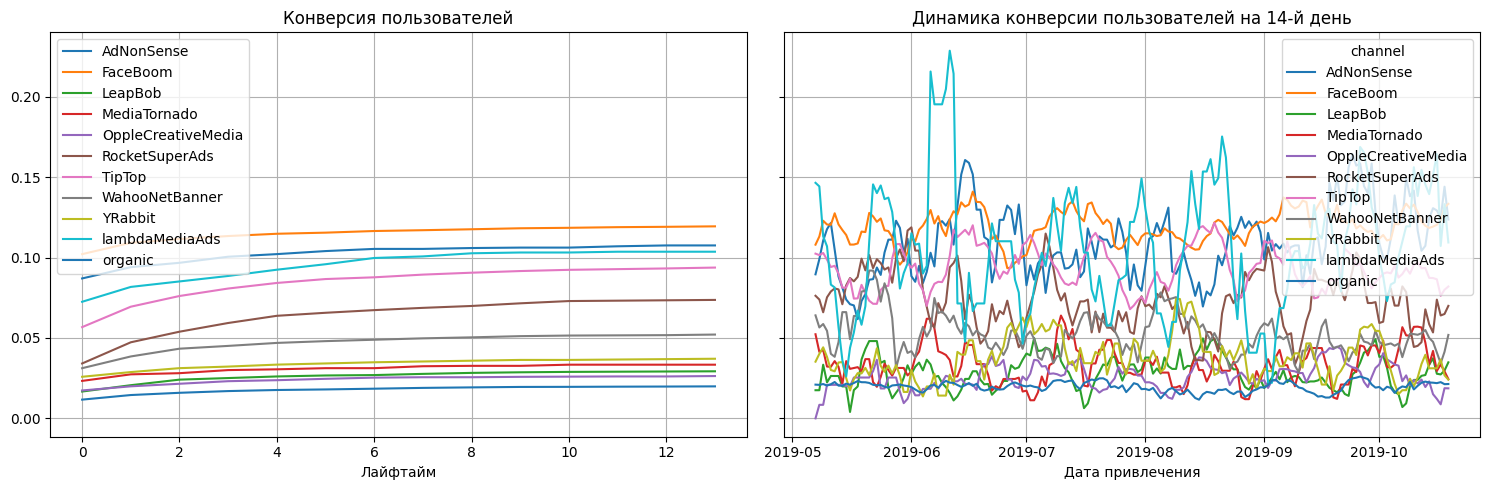

In [43]:
result_raw_conv, result_grouped_conv, result_in_time_conv = get_conversion(
                                    profiles_with_org, orders, analysis_moment, horizon_days, dimensions=['channel'])
plot_conversion(result_grouped_conv, result_in_time_conv, horizon_days, 7)

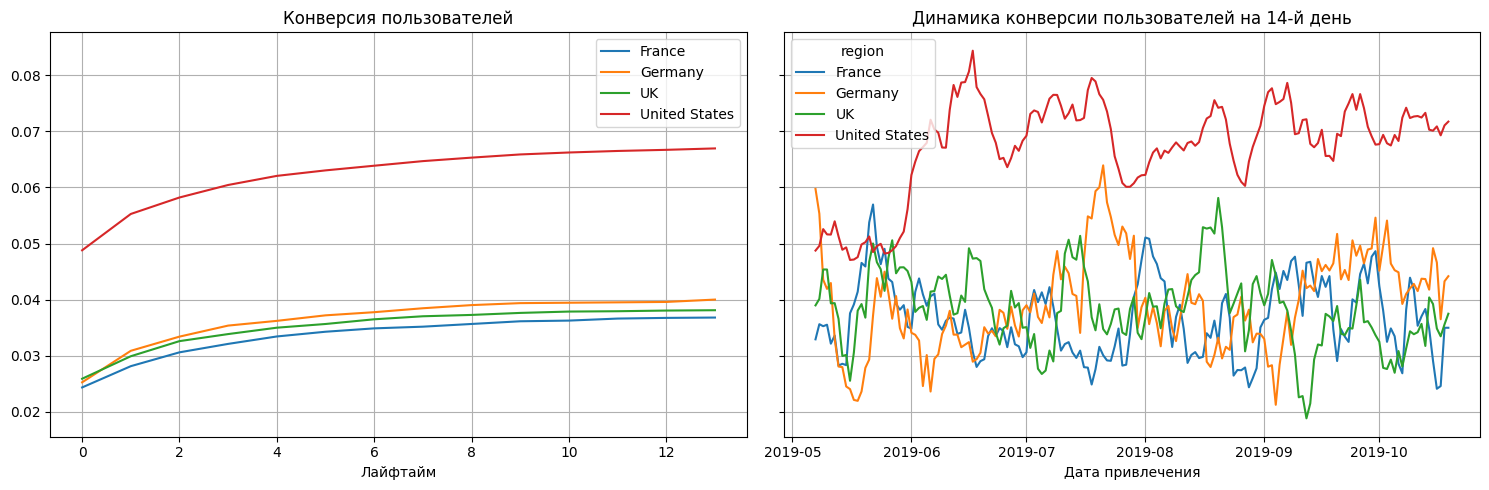

In [44]:
result_raw_conv, result_grouped_conv, result_in_time_conv = get_conversion(
                                    profiles_with_org, orders, analysis_moment, horizon_days, dimensions=['region'])
plot_conversion(result_grouped_conv, result_in_time_conv, horizon_days, 7)

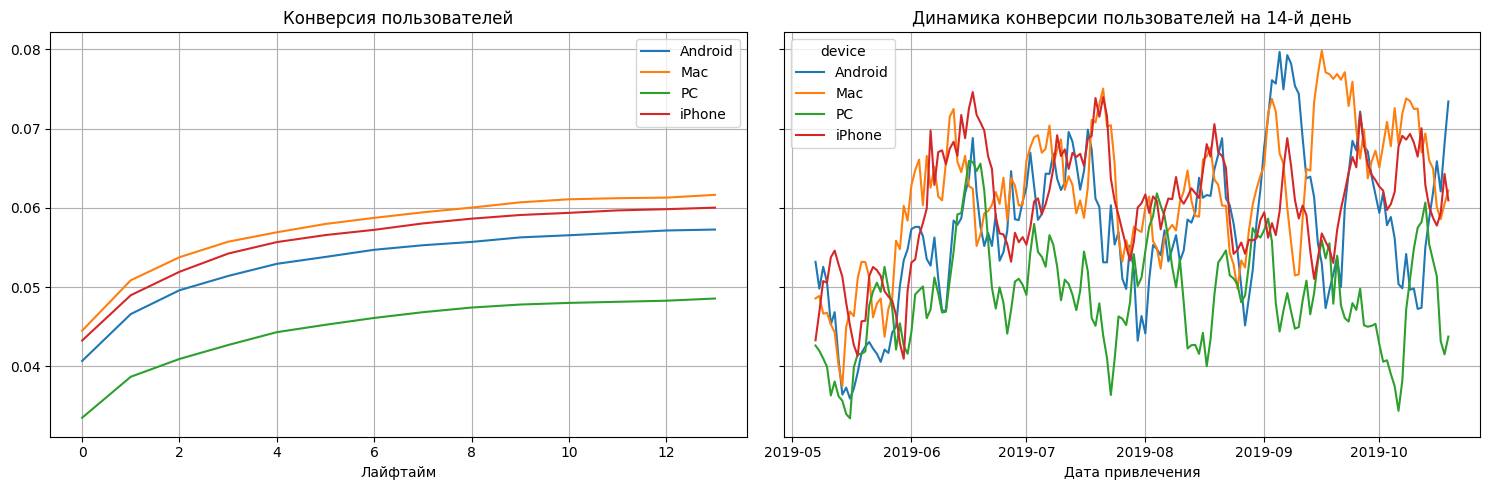

In [45]:
result_raw_conv, result_grouped_conv, result_in_time_conv = get_conversion(
                                    profiles_with_org, orders, analysis_moment, horizon_days, dimensions=['device'])
plot_conversion(result_grouped_conv, result_in_time_conv, horizon_days, 7)

Самая лучшая конверсия у 4 рекламных источников: FaceBoom, AdNonSense, lambdaMediaAds и TipTop.   
Среди стран лучшая конверсия у США, в два раза больше по сравнению с европейскими странами. К сожалению, привлечение американских пользователей не окупилось.   
У PC самый худший показатель конверсии среди устройств - 3%. У других устройств - около 6%.

#### Объединим пользователей из европейских стран и рассмотрим бизнес-показатели в разрезе США-Европа.

In [46]:
profiles_eur = profiles.replace(['France', 'Germany', 'UK'], 'Europe')
profiles_with_org_eur = profiles_with_org.replace(['France', 'Germany', 'UK'], 'Europe')

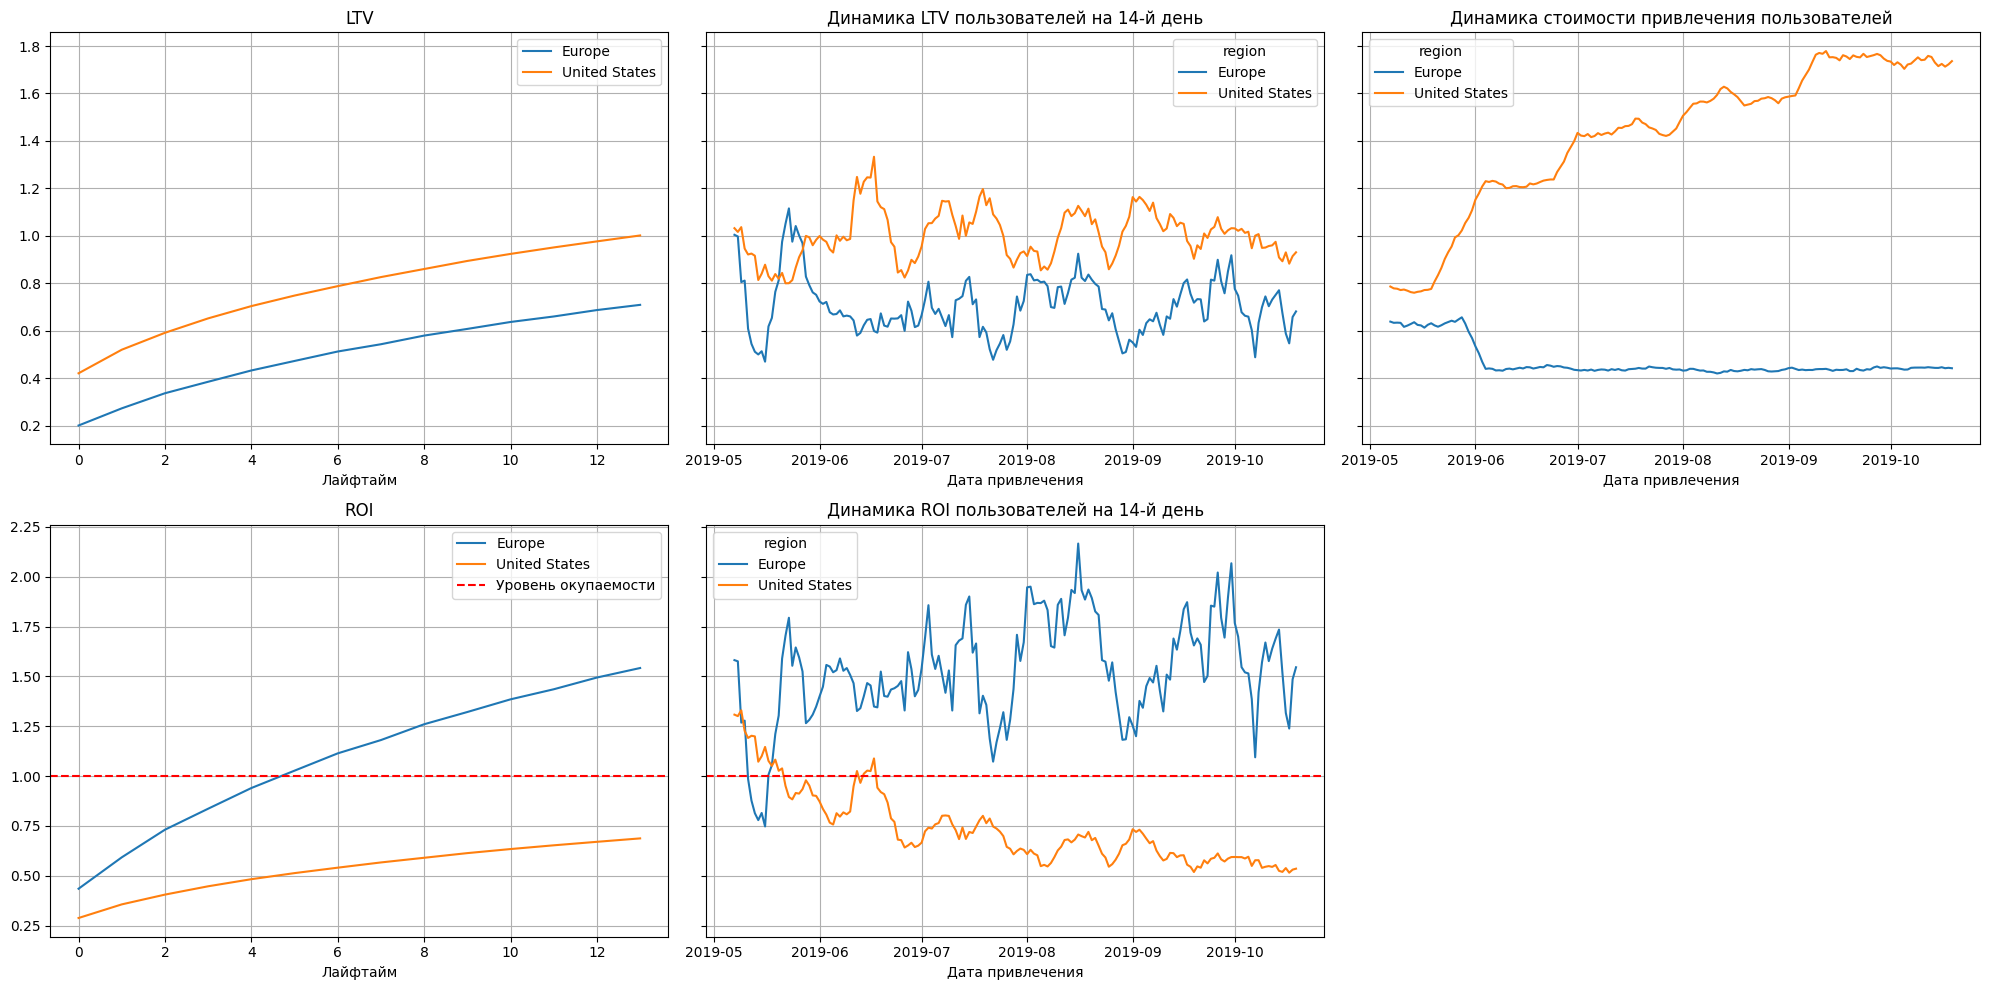

In [47]:
result_raw_ltv, result_ltv, result_in_time_ltv, roi, roi_in_time = get_ltv(
                                                                    profiles_eur, orders, analysis_moment, horizon_days,
                                                                                            dimensions=['region'])
plot_ltv_roi(result_ltv, result_in_time_ltv, roi, roi_in_time, horizon_days)

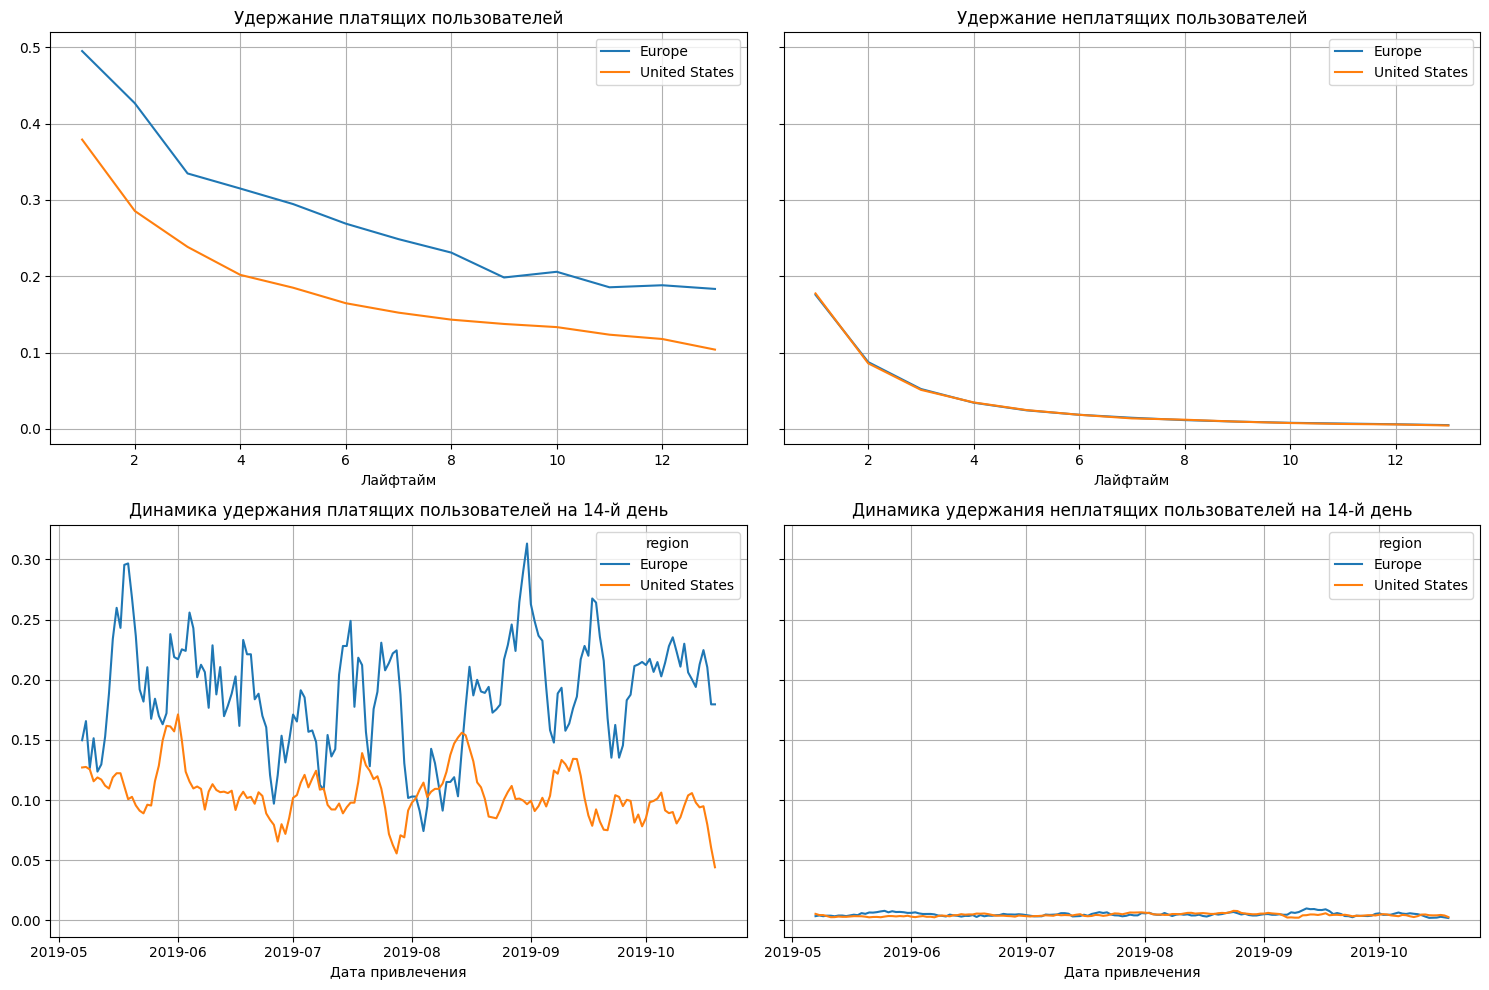

In [48]:
result_raw_ret, result_ret, result_in_time_ret= get_retention(profiles_with_org_eur, visits, analysis_moment, horizon_days,
                                                                dimensions=['region'])
plot_retention(result_ret, result_in_time_ret, horizon_days, 7)

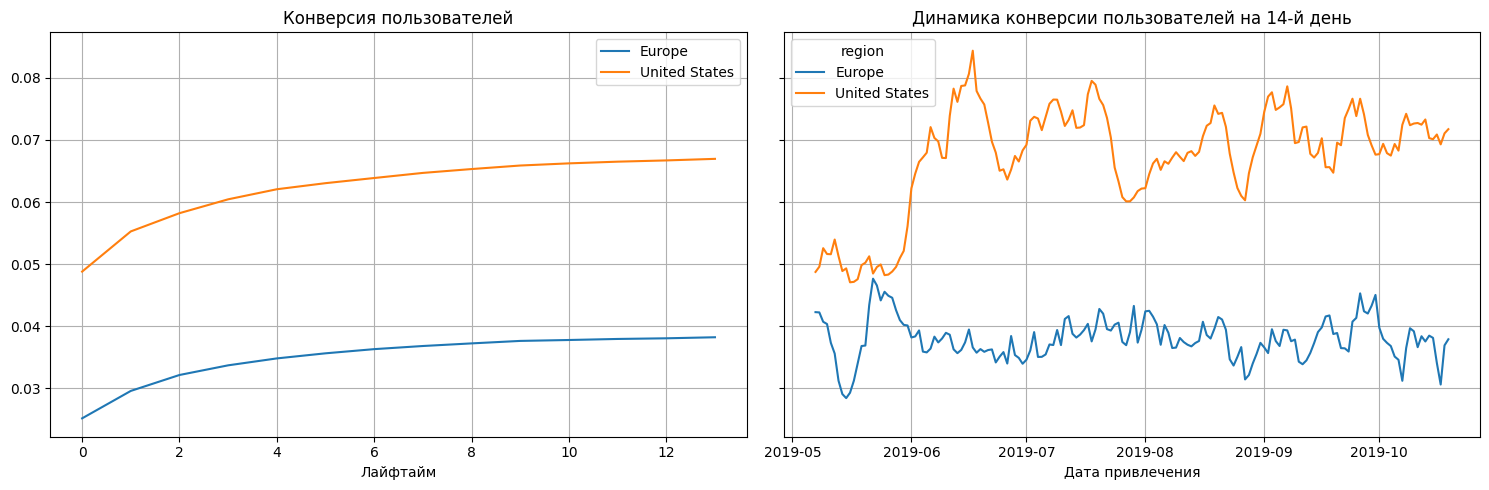

In [49]:
result_raw_conv, result_grouped_conv, result_in_time_conv = get_conversion(
                                    profiles_with_org_eur, orders, analysis_moment, horizon_days, dimensions=['region'])
plot_conversion(result_grouped_conv, result_in_time_conv, horizon_days, 7)

Европейские пользователи окупаются уже на 5 лайфтайм и окупаются через 2 недели на 150%. Привлечение европейских пользователей в 4 раза дешевле чем американских. Однако конверсия в платных пользователей меньше чем у американских.

## Финальные выводы

*Окупается ли реклама, направленная на привлечение пользователей в целом?*   
   
Если взять за горизонт анализа 14 дней, то реклама не окупается. ROI близок к 100%, однако не пересекает порог окупаемости. С начала периода видно, что ROI падает, а CAC растёт. Уже с середины июля ROI не перескал порог окупаемости.

*Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?*   
* страны: США;
* рекламные каналы: AdNonSense, FaceBoom, TipTop.   

*Чем могут быть вызваны проблемы окупаемости?*    
    
Рост стоимости привлечения пользователей для пользователей из США, а также по источнику TipTop.

*Причины неэффективности привлечения пользователей*:   
   
* Из 100 тыс. долларов рекламного бюджета 86 тыс.долларов было вложено в рекламные источники FaceBoom, TipTop, однако эти вложения не окупились.   
* FaceBoom и TipTop привлекают только пользователей из США. При этом прибыль от пользователей из США меньше, чем расходы на их привлечение. Пользователи из других стран окупаются уже в 3 день лайфтайма и за две недели достигают 200%.   
* У пользователей, пришедших из канала TipTop, очень слабый коэффциент удержания, а также среди них мало платящих пользователей. Видимо, источник привлекает пользователей, которым приложение неактуально. 
   
*Рекомендации для отдела маркетинга*:   
   
* Сфокусироваться на привлечение пользователей из Франции, Германии и Великобритании. Не стоит вкладываться в рекламу через FaceBoom и TipTop, так 